# Hands-on session 3: Elephant (Solution)

These exercises build on concepts introduced in Tutorial 3

In this exercise, we will use the SPADE method of Elephant to find recurring patterns in the spike data of trial 1.


## Imports and Preparation

In [1]:
import quantities as pq
import neo.utils
import elephant
import viziphant

On Linux you can download the compiled nix file via the command below. On other systems, please download the file manually from here and save it in the same folder as this notebook.

In [2]:
!wget -O i140703-001.nix https://gin.g-node.org/sprenger/multielectrode_grasp/raw/dataset_nix/datasets_nix/i140703-001_cut_74sec.nix

## Data preparation


1. Load the data `i140703-001.nix` file using the `neo.io.NixIO` into a neo Block.

In [3]:
with neo.io.NixIO('i140703-001.nix', 'ro') as io:
    block = io.read_block()
segment = block.segments[0]

2. In close analogy to the beginning of tutorial 3, prepare a Neo `Block`, containing one `Segment` of SGHF data of the first correct trial. Name this `Segement` by the variable `trial`, as in tutorial 3.  In contrast to the lecture, we will cut data from the trial start `TS-ON` to reward administration indicated by event `RW-ON`. To this end, first find also the `RW-ON` events similar to how we found `TS-ON` in tutorial 3. Then, in the call to `neo.utils.add_epoch()`, supply these as a second event `event2=` *instead* of giving `t_pre=0` and `t_post=2*pq.s`. This will cut from event 1 to event 2, instead of a fixed amount of 2 s around event 1 (as in tutorial 3).

In [4]:
start_events = neo.utils.get_events(
    segment,
    trial_event_labels='TS-ON',
    belongs_to_trialtype='SGHF',
    performance_in_trial_str='correct_trial')

## Additinally, get RW-ON events
stop_events = neo.utils.get_events(
    segment,
    trial_event_labels='RW-ON',
    belongs_to_trialtype='SGHF',
    performance_in_trial_str='correct_trial')

In [5]:
# Create epochs between the events
trial_epochs = neo.utils.add_epoch(
    segment,
    event1=start_events[0],     # The function returns a list, we need to retrieve the object which is the first (digital port events)
    event2=stop_events[0],
    array_annotations=start_events[0].array_annotations)

In [6]:
# Create the new block
trials = neo.Block()

# Cut the recording segment into the trials, as defined by the epochs
trials.segments = neo.utils.cut_segment_by_epoch(segment, trial_epochs, reset_time=True)

In [7]:
# Select first segment as the trial for analysis
trial = trials.segments[0]

## SPADE analysis

Note that patterns in this data are not easily to spot by eye in the rasterplot we developed in tutorial 3.
We use SPADE as a technique that does that for us by finding all patterns and checking for each pattern if it
occurs more often than expected given its complexity (number of neurons participating) and frequency.
Before going directly to the analysis we briefly explain SPADE's most important parameters:

- `binsize`: temporal precision of the method. The smaller the binsize is, the more precisely we expect each single pattern to repeat. This raises an important question: which is the temporal precision that are you interested in? It depends on the scientific question! We often use 5ms, based on a number of studies on the minimal neuronal temporal precision.
- `winlen`: window length, or maximal length allowed to each pattern, expressed in bin units. SPADE will detect patterns with a temporal duration up to the window length. If winlen=1, then only synchronous patterns are detected. Are you interested in synchronous higher-order correlations? Are you interested in patterns with delays? Note: the higher the winlen parameter is, the more expensive (memory and time) the pattern search is!
- `min_spikes` and `min_neu`: minimum number of spikes and minimum number of neurons allowed in a pattern. These parameters are important, too. Do you want to look for pattern with a particular size? Are you interested in patterns with multiple spikes coming from the same neuron?
- `n_surr`: number of surrogates used for the statistical testing. If the number of surrogates is set to zero, then all patterns are retrieved by SPADE without further testing. If, instead, the number of surrogates is different from zero (typically we suggest to use a large number - the more the better!) then only the significant patterns are retrieved from the analysis. For simplicity, we will set this parameter to `n_surr=0` in the following.

Next steps:
3. As in tutorial 3, select only good quality neurons using the annotations (i.e., SUA units, more than 10000 spikes,...)

In [8]:
# Select only SUA spike trains with spikes and certain quality criteria
spiketrains = [spiketrain for spiketrain in trial.spiketrains if
                                   spiketrain.annotations['sua'] and
                                   not spiketrain.annotations['electrode_reject_HFC'] and
                                   not spiketrain.annotations['electrode_reject_IFC'] and
                                   not spiketrain.annotations['electrode_reject_LFC'] and
                                   not spiketrain.annotations['noise'] and
                                   spiketrain.annotations['spike_count'] > 10000]

4. Run the SPADE analysis by executing the code given below:

In [9]:
# Fix parameters for SPADE
binsize = 5 * pq.ms
winlen = 1
min_spikes = 2
n_surr = 0
min_neu = 2
min_occ = 2

In [10]:
result = elephant.spade.spade(
        spiketrains=spiketrains, binsize=binsize, winlen=winlen,
        min_spikes=min_spikes, n_surr=n_surr, min_neu=min_neu, min_occ=min_occ)
patterns = result['patterns']

/home/denker/miniconda3/envs/2021_nix_workshop/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 2 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


Time for data mining: 0.1820077896118164


6. Let's look at the output in `patterns`. How many patterns were found? How does one pattern look as an output?

In [11]:
# Print the length of the list of patterns found, and the first pattern as an example
len(patterns), patterns[0]

(5346,
 {'itemset': (22, 50),
  'windows_ids': (127, 192),
  'neurons': [22, 50],
  'lags': array([0.]) * ms,
  'times': array([635., 960.]) * ms,
  'signature': (2, 2),
  'pvalue': -1})

7. Display five detected patterns in the data and their statistics by executing the Viziphant function calls given below

<AxesSubplot:xlabel='Time (s)', ylabel='Neuron'>

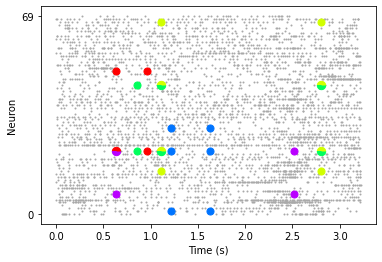

In [12]:
viziphant.spade.plot_patterns(spiketrains, patterns[:5], circle_sizes=(1, 50, 70))


(<Figure size 720x576 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Patterns statistics'}, xlabel='Neuronal participation in patterns', ylabel='Count'>,
        <AxesSubplot:xlabel='Pattern occurrences', ylabel='Count'>,
        <AxesSubplot:xlabel='Pattern size', ylabel='Count'>], dtype=object))

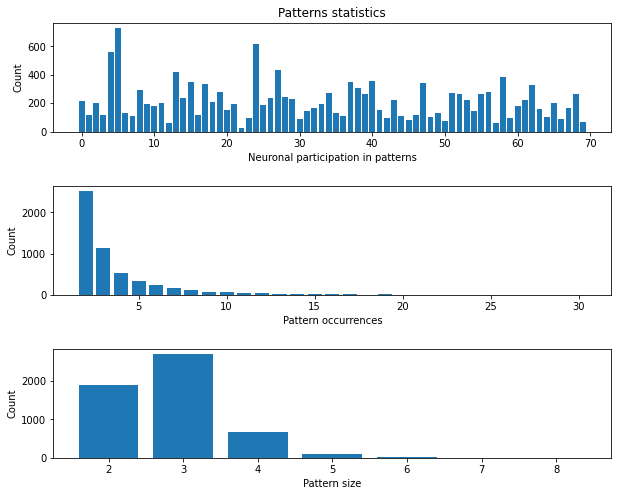

In [13]:
viziphant.spade.plot_patterns_statistics(patterns)